In [1]:
!pip install --quiet torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.7 MB/s eta 0:00:00


In [2]:
# ====== Colab-ready DOA Graph Embedding (Edge-aware Attention GNN) ======
# !pip install hdbscan  # Optional, only if you want HDBSCAN in evaluate()

import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

In [3]:
# -----------------------------
# Config
# -----------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GRID_SIZE = 10.0
NUM_SENSORS = 10
POS_STD = 0.5
EDGE_MAX_CPA_CLIP = 5.0
EMBED_DIM = 64

# For training/demo scene generation
MIN_NOISE = 0.3
MAX_NOISE = 2.0
P_MISS = 0.3
P_FALSE = 0.2
SINGLE_PER_SENSOR_RATIO = 0.25
MIN_TARGET_SEP = 2.0  # <---- minimum Euclidean separation between two targets



# Grid of candidate target points
GRID_X = np.linspace(0, GRID_SIZE, 500)
GRID_Y = np.linspace(0, GRID_SIZE, 500)
train_targets_grid = np.array([(x, y) for x in GRID_X for y in GRID_Y], dtype=np.float32)

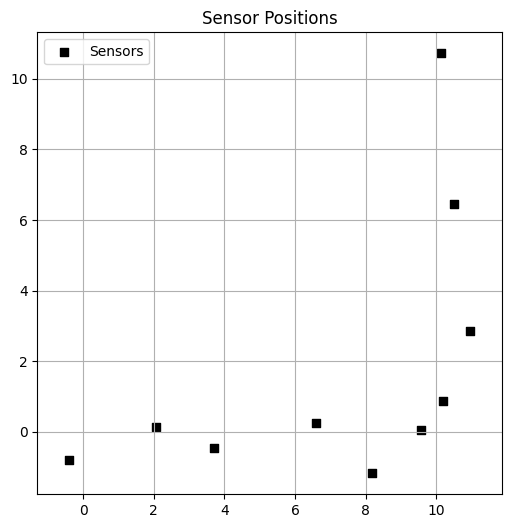

In [4]:
# -----------------------------
# Sensor array (L-shape, like your code)
# -----------------------------
def build_lshape_sensors(grid_size=GRID_SIZE, num_sensors=NUM_SENSORS, pos_std=POS_STD, seed=120):
    rng = np.random.default_rng(seed)
    num_right = num_sensors // 2 - 1
    num_bottom = num_sensors - num_right

    right_x = np.full(num_right, grid_size + 0.5) + rng.normal(0, pos_std, num_right)
    right_y = np.linspace(0, grid_size, num_right) + rng.normal(0, pos_std, num_right)

    bottom_x = np.linspace(0, grid_size, num_bottom) + rng.normal(0, pos_std, num_bottom)
    bottom_y = np.full(num_bottom, -0.5) + rng.normal(0, pos_std, num_bottom)

    sensors = np.column_stack([np.concatenate([right_x, bottom_x]),
                               np.concatenate([right_y, bottom_y])])
    return sensors

SENSOR_POSITIONS = build_lshape_sensors()

# Plot sensor positions
plt.figure(figsize=(6, 6))
plt.scatter(SENSOR_POSITIONS[:, 0], SENSOR_POSITIONS[:, 1], c='black', marker='s', label='Sensors')
plt.title("Sensor Positions")
plt.grid(True)
plt.axis('equal')
plt.legend()
plt.show()

In [5]:
# -----------------------------
# Target sampling with min separation
# -----------------------------
def sample_targets_from_grid(grid_pts, num_targets, min_sep=MIN_TARGET_SEP, rng=None):
    """
    grid_pts: (M,2)
    Returns list of 1 or 2 targets with min separation if 2.
    """
    if rng is None:
        rng = np.random.default_rng()

    if num_targets == 1:
        i = rng.integers(0, len(grid_pts))
        return [tuple(grid_pts[i])]

    # num_targets == 2: sample first, then filter candidates for the second by min distance
    i1 = rng.integers(0, len(grid_pts))
    t1 = grid_pts[i1]
    # mask candidates within min_sep
    d2 = np.sum((grid_pts - t1) ** 2, axis=1)
    keep = d2 >= (min_sep ** 2)
    viable = grid_pts[keep]
    if len(viable) == 0:
        # fallback: relax constraint a bit
        keep = d2 >= (0.5 * min_sep) ** 2
        viable = grid_pts[keep]
        if len(viable) == 0:
            viable = grid_pts

    i2 = rng.integers(0, len(viable))
    t2 = viable[i2]
    return [tuple(t1), tuple(t2)]

# -----------------------------
# Scene generation (your logic, untouched except using sampler above)
# -----------------------------
def generate_scene_from_targets(
    sensors,
    target_list,
    noise_std=2.5,
    p_miss=0.3,
    p_false=0.2,
    single_per_sensor_ratio=0.25
):
    """
    Returns:
        measurements: (n_meas, 4)  [x_sensor, y_sensor, cos(theta), sin(theta)]
        labels:       (n_meas,)    target index or -1 for outlier
        target_list:  (n_targets, 2)
        sensor_ids:   (n_meas,)    which sensor index each measurement is from
        true_angles:  (n_meas,)    true azimuth (rad)
    """
    measurements, labels, sensor_ids, true_angles = [], [], [], []

    n_targets = len(target_list)
    for s_idx, sensor in enumerate(sensors):
        if n_targets == 2 and np.random.rand() < single_per_sensor_ratio:
            # only one of the two true targets (maybe)
            t_idx = np.random.randint(0, 2)
            if np.random.rand() > p_miss:
                vec = target_list[t_idx] - sensor
                azimuth = np.arctan2(vec[1], vec[0])
                noisy_azimuth = azimuth + np.radians(np.random.randn() * noise_std)
                angle = [np.cos(noisy_azimuth), np.sin(noisy_azimuth)]
                measurements.append([sensor[0], sensor[1], angle[0], angle[1]])
                labels.append(t_idx)
                sensor_ids.append(s_idx)
                true_angles.append(azimuth)
            if np.random.rand() < p_false:
                min_angle_diff = np.radians(8)
                attempts = 0
                while True:
                    outlier_angle = np.random.uniform(-np.pi, np.pi)
                    vecs = target_list - sensor
                    target_angles = np.arctan2(vecs[:, 1], vecs[:, 0])
                    diffs = np.abs(np.unwrap(target_angles - outlier_angle))
                    if np.all(diffs > min_angle_diff) or attempts > 50:
                        break
                    attempts += 1
                angle = [np.cos(outlier_angle), np.sin(outlier_angle)]
                measurements.append([sensor[0], sensor[1], angle[0], angle[1]])
                labels.append(-1)
                sensor_ids.append(s_idx)
                true_angles.append(outlier_angle)
        else:
            for t_idx, target in enumerate(target_list):
                if np.random.rand() > p_miss:
                    vec = target - sensor
                    azimuth = np.arctan2(vec[1], vec[0])
                    noisy_azimuth = azimuth + np.radians(np.random.randn() * noise_std)
                    angle = [np.cos(noisy_azimuth), np.sin(noisy_azimuth)]
                    measurements.append([sensor[0], sensor[1], angle[0], angle[1]])
                    labels.append(t_idx)
                    sensor_ids.append(s_idx)
                    true_angles.append(azimuth)
                if np.random.rand() < p_false:
                    min_angle_diff = np.radians(8)
                    attempts = 0
                    while True:
                        outlier_angle = np.random.uniform(-np.pi, np.pi)
                        vecs = target_list - sensor
                        target_angles = np.arctan2(vecs[:, 1], vecs[:, 0])
                        diffs = np.abs(np.unwrap(target_angles - outlier_angle))
                        if np.all(diffs > min_angle_diff) or attempts > 50:
                            break
                        attempts += 1
                    angle = [np.cos(outlier_angle), np.sin(outlier_angle)]
                    measurements.append([sensor[0], sensor[1], angle[0], angle[1]])
                    labels.append(-1)
                    sensor_ids.append(s_idx)
                    true_angles.append(outlier_angle)

    return (
        np.array(measurements, dtype=np.float32),
        np.array(labels, dtype=np.int64),
        np.array(target_list, dtype=np.float32),
        np.array(sensor_ids, dtype=np.int64),
        np.array(true_angles, dtype=np.float32),
    )

def generate_train_scene(
    epoch=0, max_epochs=25,
    min_noise=MIN_NOISE, max_noise=MAX_NOISE,
    p_miss=P_MISS, p_false=P_FALSE,
    single_per_sensor_ratio=SINGLE_PER_SENSOR_RATIO,
    min_target_sep=MIN_TARGET_SEP,
    num_targets=None
):
    """
    Progressive noise schedule across epochs; 1 or 2 targets with min separation.
    """
    if num_targets is None:
      num_targets = random.choice([1, 2])
    targets = sample_targets_from_grid(train_targets_grid, num_targets, min_sep=min_target_sep)
    frac = min(epoch / max_epochs, 1.0)
    noise_std = min_noise + (max_noise - min_noise) * frac

    measurements, labels, target_list, sensor_ids, true_angles = generate_scene_from_targets(
        SENSOR_POSITIONS, np.array(targets, dtype=np.float32),
        noise_std=noise_std,
        p_miss=p_miss,
        p_false=p_false,
        single_per_sensor_ratio=single_per_sensor_ratio
    )
    return measurements, labels, target_list, sensor_ids, num_targets, true_angles


In [6]:
# ===== Upgrades: coord normalization, top-K edges, geo-gated multi-head attention, better count pooling =====

# 1) constants
EDGE_FEAT_DIM = 14   # [xg, yg, ti, tj, cpa, cos_rel, sin_rel, dx, dy, dsens, in_front, parallel, inside]
NORM_COORDS   = True
ATT_HEADS     = 4
EDGE_TOPK     = 12

# If you previously used a world-space CPA clip (e.g., 5.0 for grid=10),
# after normalization to [-0.5,0.5] the scale is ~1/grid_size.
CPA_CLIP_NORM = (EDGE_MAX_CPA_CLIP / GRID_SIZE) if 'EDGE_MAX_CPA_CLIP' in globals() else 0.5 / GRID_SIZE

def _closest_approach_2rays(p_i, d_i, p_j, d_j, eps=1e-6):
    A = np.stack([d_i, -d_j], axis=1)
    b = (p_j - p_i)
    det = np.linalg.det(A)
    if abs(det) < eps:
        t_i = np.dot(b, d_i)  # project onto di
        t_j = 0.0
        pi = p_i + t_i * d_i
        pj = p_j
        mid = 0.5 * (pi + pj)
        cpa_dist = np.linalg.norm(pi - pj)
        return mid[0], mid[1], t_i, t_j, cpa_dist, True
    sol = np.linalg.solve(A, b)
    t_i, t_j = float(sol[0]), float(sol[1])
    pi = p_i + t_i * d_i
    pj = p_j + t_j * d_j
    mid = 0.5 * (pi + pj)
    cpa_dist = float(np.linalg.norm(pi - pj))
    return mid[0], mid[1], t_i, t_j, cpa_dist, False

def build_graph_from_meas(meas, sensor_ids, grid_size=GRID_SIZE, norm_coords=NORM_COORDS, cpa_clip=CPA_CLIP_NORM):
    """
    Node feat: [x_norm, y_norm, cos, sin] with coords in [-0.5,0.5]
    Edge feat (14):
      [xg, yg, ti, tj, cpa, cos_rel, sin_rel, dx, dy, dsens, in_front, parallel, inside, same_sensor]
    """
    meas = np.asarray(meas, dtype=np.float32).copy()
    sensor_ids = np.asarray(sensor_ids, dtype=np.int64)
    if norm_coords:
        meas[:, 0:2] = meas[:, 0:2] / (grid_size + 1e-9) - 0.5

    N = meas.shape[0]
    node_feat = torch.tensor(meas, dtype=torch.float32)

    edge_src, edge_dst, edge_feats = [], [], []
    for i in range(N):
        pi = meas[i, :2]
        di = meas[i, 2:4]; di /= (np.linalg.norm(di)+1e-9)
        for j in range(N):
            if i == j:
                continue  # no self-edge
            pj = meas[j, :2]
            dj = meas[j, 2:4]; dj /= (np.linalg.norm(dj)+1e-9)

            # same-sensor flag
            same = float(sensor_ids[i] == sensor_ids[j])

            # closest approach (works fine for same-origin too; gives mid ~ sensor, cpa ~ 0)
            xi, yi, ti, tj, cpa, parallel = _closest_approach_2rays(pi, di, pj, dj)
            cpa = min(cpa, cpa_clip)

            # relative angle
            dot = float(np.clip(np.dot(di, dj), -1.0, 1.0))
            rel = math.acos(dot)
            cross_z = di[0]*dj[1] - di[1]*dj[0]
            sin_rel = math.sin(rel) * (1.0 if cross_z >= 0 else -1.0)
            cos_rel = math.cos(rel)

            # sensor deltas in normalized space
            dx_sens, dy_sens = (pj - pi).tolist()
            dsens = math.sqrt(dx_sens**2 + dy_sens**2)

            # in_front: for same-sensor edges we mark 0 (degenerate); otherwise ti>=0 & tj>=0
            in_front = 0.0 if same > 0.5 else (1.0 if (ti >= 0.0 and tj >= 0.0) else 0.0)

            # inside the normalized grid
            inside = 1.0 if (-0.5 <= xi <= 0.5 and -0.5 <= yi <= 0.5) else 0.0

            # map to [0,1] for xg, yg (even though coordinates are normalized)
            xg, yg = xi + 0.5, yi + 0.5

            feat = [xg, yg, ti, tj, cpa, cos_rel, sin_rel,
                    dx_sens, dy_sens, dsens,
                    in_front, float(parallel), inside,
                    same]  # <-- new bit at index 13
            edge_src.append(i); edge_dst.append(j); edge_feats.append(feat)

    edge_index = torch.tensor([edge_src, edge_dst], dtype=torch.long)
    edge_attr  = torch.tensor(edge_feats, dtype=torch.float32) if edge_feats else torch.zeros((0, EDGE_FEAT_DIM), dtype=torch.float32)
    return node_feat, edge_index, edge_attr


@torch.no_grad()
def sparsify_edges(edge_index, edge_attr, K=EDGE_TOPK):
    if edge_index.numel() == 0:
        return edge_index, edge_attr
    src, dst = edge_index
    cpa      = edge_attr[:, 4]
    in_front = edge_attr[:,10]
    inside   = edge_attr[:,12]
    sin_rel  = edge_attr[:, 6].abs()
    same     = edge_attr[:,13]     # <-- new

    # lower is better: prefer small CPA, in-front, inside; slightly penalize same-sensor edges
    score = cpa - 2.0*in_front - 0.5*inside + 0.1*sin_rel + 0.6*same

    keep = torch.zeros_like(cpa, dtype=torch.bool)
    for v in torch.unique(dst):
        m = (dst == v)
        k = min(K, int(m.sum()))
        if k == 0:
            continue
        local_idx  = torch.topk(-score[m], k).indices
        global_idx = m.nonzero(as_tuple=False).squeeze(1)[local_idx]
        keep[global_idx] = True
    return edge_index[:, keep], edge_attr[keep]

In [7]:
# ===== Activation-upgraded multi-head edge-aware GNN =====

def get_activation(name: str):
    name = (name or "gelu").lower()
    if name in ("gelu",):
        return nn.GELU()
    if name in ("silu", "swish"):
        return nn.SiLU()
    if name in ("relu",):
        return nn.ReLU()
    if name in ("leakyrelu", "lrelu"):
        return nn.LeakyReLU(0.1)
    raise ValueError(f"Unknown activation: {name}")

class MHEdgeAttentionLayer(nn.Module):
    """
    Multi-head edge-aware attention with a geometry gate on messages.
    Uses configurable activation in the message/edge MLPs.
    """
    def __init__(self, in_dim, edge_dim, out_dim, heads=ATT_HEADS, dropout=0.0, act="gelu"):
        super().__init__()
        assert out_dim % heads == 0, "out_dim must be divisible by heads"
        self.h = heads
        self.dk = out_dim // heads
        self.lin_src = nn.Linear(in_dim, out_dim, bias=False)
        self.lin_dst = nn.Linear(in_dim, out_dim, bias=False)
        self.lin_edge= nn.Linear(edge_dim, out_dim, bias=False)
        self.att_vec = nn.Parameter(torch.zeros(heads, self.dk))
        nn.init.xavier_uniform_(self.att_vec)
        self.act = get_activation(act)

        self.msg_mlp = nn.Sequential(
            nn.Linear(out_dim, out_dim),
            self.act,
            nn.Dropout(dropout),
            nn.Linear(out_dim, out_dim)
        )
        self.update = nn.GRUCell(out_dim, out_dim)
        self.dropout = nn.Dropout(dropout)

        # geometry gate (ends with sigmoid, inner nonlinearity = chosen activation)
        self.edge_gate = nn.Sequential(
            nn.Linear(edge_dim, out_dim),
            self.act,
            nn.Linear(out_dim, 1),
            nn.Sigmoid()
        )
        self.ln = nn.LayerNorm(out_dim)

    def forward(self, x, edge_index, edge_attr):
        if edge_index.numel() == 0:
            return x
        N = x.size(0)
        src, dst = edge_index
        hs = self.lin_src(x)[src].view(-1, self.h, self.dk)  # [E,H,dk]
        hd = self.lin_dst(x)[dst].view(-1, self.h, self.dk)  # [E,H,dk]
        he = self.lin_edge(edge_attr).view(-1, self.h, self.dk)

        # Keep tanh here for bounded/robust attention logits
        u = torch.tanh(hs + hd + he)                         # [E,H,dk]
        logits = (u * self.att_vec).sum(-1)                  # [E,H]

        alpha = torch.zeros_like(logits)
        for v in torch.unique(dst):
            m = (dst == v)
            a = logits[m]
            a = a - a.max(dim=0, keepdim=True).values
            alpha[m] = torch.softmax(a, dim=0)

        gate = self.edge_gate(edge_attr).squeeze(-1)         # [E]
        m = (hs + he) * alpha.unsqueeze(-1)                  # [E,H,dk]
        m = m.reshape(m.size(0), -1)                         # [E,out_dim]
        m = self.msg_mlp(m) * gate.unsqueeze(-1)             # [E,out_dim]

        agg = torch.zeros(N, m.size(1), device=x.device)
        agg.index_add_(0, dst, m)

        agg = self.dropout(agg)
        out = self.update(agg, x)
        return self.ln(x + out)

class EdgeAwareDOAGNN(nn.Module):
    """
    Ray↔ray GNN with:
      - coord normalization in graph build,
      - top-K edges per dst,
      - multi-head edge-aware attention with geometry gate,
      - GELU/SILU activations (configurable),
      - mean+max pooling for target-count head.
    """
    def __init__(self, node_dim=4, edge_dim=EDGE_FEAT_DIM, hidden=64, num_layers=3, emb_dim=64,
                 heads=ATT_HEADS, edge_topk=EDGE_TOPK, dropout=0.0, act="gelu"):
        super().__init__()
        self.edge_topk = edge_topk
        self.act = get_activation(act)

        self.inp = nn.Linear(node_dim, hidden)
        self.layers = nn.ModuleList([
            MHEdgeAttentionLayer(hidden, edge_dim, hidden, heads=heads, dropout=dropout, act=act)
            for _ in range(num_layers)
        ])

        self.emb_head = nn.Sequential(
            nn.Linear(hidden, hidden),
            self.act,
            nn.Linear(hidden, emb_dim)
        )
        self.outlier_head = nn.Sequential(
            nn.Linear(hidden, hidden//2),
            self.act,
            nn.Linear(hidden//2, 1)
        )
        self.count_head = nn.Sequential(
            nn.Linear(2*hidden, hidden),
            self.act,
            nn.Linear(hidden, 2)
        )

    def _forward_single(self, meas_np, sensor_ids):
        node_feat, edge_index, edge_attr = build_graph_from_meas(meas_np, sensor_ids, norm_coords=NORM_COORDS)
        x  = node_feat.to(DEVICE)
        ei = edge_index.to(DEVICE)
        ea = edge_attr.to(DEVICE)

        # ei, ea = sparsify_edges(ei, ea, K=self.edge_topk)

        h = self.inp(x)
        for layer in self.layers:
            h = layer(h, ei, ea)

        emb = self.emb_head(h)                        # [N, D]
        outlier_logit = self.outlier_head(h).squeeze(-1)
        g_mean = h.mean(dim=0, keepdim=True)
        g_max  = h.max(dim=0, keepdim=True).values
        g = torch.cat([g_mean, g_max], dim=-1)
        target_logits = self.count_head(g).squeeze(0)
        return emb, outlier_logit, target_logits

    def forward_with_sensor_ids(self, x_batch, sensors_ids_list):
        outs = []
        for meas_np, sids in zip(x_batch, sensors_ids_list):
            if isinstance(meas_np, torch.Tensor):
                meas_np = meas_np.detach().cpu().numpy()
            outs.append(self._forward_single(meas_np, sids))
        return outs

In [8]:
def outlier_repulsion_losses(z, labels, alpha=0.2, proto_radius=1.0):
    """
    z: [N,D] (not necessarily normalized); labels: [N] (int), -1 = outlier
    Returns: L_cos_rep, L_proto_rep
    """
    if z.numel() == 0:
        zero = z.sum() * 0.0
        return zero, zero

    # normalize for cosine
    zn = F.normalize(z, dim=-1)
    labels = labels.view(-1)
    inlier_mask = labels >= 0
    out_mask = labels < 0

    if inlier_mask.sum() == 0 or out_mask.sum() == 0:
        zero = z.sum() * 0.0
        return zero, zero

    z_in = zn[inlier_mask]   # [Ni,D]
    z_out = zn[out_mask]     # [No,D]

    # ---- (1) Outlier–Inlier cosine margin repel ----
    # cos matrix: [No,Ni]
    cos_oi = torch.matmul(z_out, z_in.T)
    # hinge on (cos - alpha): penalize if too similar
    L_cos_rep = F.relu(cos_oi - alpha).mean()

    # ---- (2) Prototype radius repel ----
    # compute per-class prototypes on ORIGINAL (unnormalized) z for geometry
    z_in_full = z[inlier_mask]
    y_in = labels[inlier_mask]
    classes = torch.unique(y_in)
    protos = []
    for c in classes:
        protos.append(z_in_full[y_in == c].mean(dim=0, keepdim=True))
    protos = torch.cat(protos, dim=0)  # [K,D]

    if protos.numel() == 0:
        L_proto_rep = z.sum() * 0.0
    else:
        # distances from outliers to each prototype: [No,K]
        d_ok = torch.cdist(z[out_mask], protos, p=2)
        # hinge on (r - dist): squared to grow gently
        L_proto_rep = F.relu(proto_radius - d_ok).pow(2).mean()

    return L_cos_rep, L_proto_rep


In [14]:
# -----------------------------
# Supervised Contrastive Loss (ignores label=-1)
# -----------------------------
class SupConLoss(nn.Module):
    """
    SupCon: normalize embeddings; for each anchor i, positives are j with same label (>=0),
    negatives are others in the scene; outliers (label=-1) are ignored entirely.
    """
    def __init__(self, temperature=0.07):
        super().__init__()
        self.tau = temperature

    def forward(self, z, labels):
        """
        z: [N, D] embeddings for one scene
        labels: [N] int64, -1 for outlier, {0,1,...} for targets
        """
        if z.numel() == 0:
            return z.sum() * 0.0
        z = F.normalize(z, dim=-1)
        N = z.size(0)
        sim = torch.matmul(z, z.t()) / self.tau  # [N,N]
        # mask out self
        logits_mask = torch.ones_like(sim, dtype=torch.bool)
        logits_mask.fill_(True)
        logits_mask.fill_diagonal_(False)

        labels = labels.view(-1)
        valid = labels >= 0
        if valid.sum() <= 1:
            # nothing to contrast
            return sim.new_tensor(0.0)

        # positives: same label & valid
        label_eq = labels.unsqueeze(0) == labels.unsqueeze(1)  # [N,N]
        pos_mask = label_eq & logits_mask & valid.unsqueeze(1) & valid.unsqueeze(0)

        # For stability, subtract max per row
        sim_max, _ = sim.max(dim=1, keepdim=True)
        sim = sim - sim_max.detach()

        exp_sim = torch.exp(sim) * logits_mask  # zero on diagonal
        # denominator: sum over all j != i
        denom = exp_sim.sum(dim=1, keepdim=True) + 1e-12

        # positive sum per i
        pos_exp = exp_sim * pos_mask
        pos_sum = pos_exp.sum(dim=1)

        # Only consider anchors that have at least one positive
        has_pos = pos_sum > 0
        if has_pos.sum() == 0:
            return sim.new_tensor(0.0)

        log_prob = torch.log(pos_sum / denom.squeeze(1) + 1e-12)
        loss = -(log_prob[has_pos]).mean()
        return loss

# TRAINING CONFIG
EPOCHS = 20
SCENES_PER_EPOCH = 500     # increase for more training
LR = 2e-3
WEIGHT_DECAY = 1e-4
SUPCON_TEMP = 0.05         # temperature for supervised contrastive loss
W_SUPCON = 1.0
W_OUTLIER_BCE = 0.2
W_TGTCOUNT_CE = 0.2
SEED = 42
PLOT_AFTER_EVERY = 10       # epochs

# -----------------------------
# TRAINING LOOP (SupCon + BCE + CE)
# -----------------------------
def train(model):
    model = model.to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    # ---- Cosine annealing: per-iteration, finish by half the run ----
    total_steps = EPOCHS * SCENES_PER_EPOCH
    FAST_DECAY_FRACTION = 1
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(
        opt,
        T_max=max(1, int(total_steps * FAST_DECAY_FRACTION)),
        eta_min=1e-6
    )

    supcon = SupConLoss(temperature=SUPCON_TEMP)
    bce = nn.BCEWithLogitsLoss()
    ce  = nn.CrossEntropyLoss()

    # repulsion terms (unchanged)
    W_OUTLIER_REPEL_COS   = 0.3
    W_OUTLIER_REPEL_PROTO = 0.2
    REPEL_ALPHA = 0.2
    PROTO_RADIUS = 1.0

    step_idx = 0
    for epoch in range(1, EPOCHS + 1):
        model.train()
        running = {"supcon":0.0, "outlier":0.0, "tgtcount":0.0,
                   "repel_cos":0.0, "repel_proto":0.0, "total":0.0}

        for ns in range(SCENES_PER_EPOCH):
            # balanced 1/2-target sampling
            meas, lbls, tgt_list, sids, num_tgts, _ = generate_train_scene(
                epoch=epoch, max_epochs=EPOCHS, min_target_sep=MIN_TARGET_SEP, num_targets=ns % 2 + 1
            )
            (emb, outlier_logit, target_logits), = model.forward_with_sensor_ids([meas], [sids])

            lbls_t = torch.tensor(lbls, dtype=torch.long, device=DEVICE)

            # losses
            loss_supcon = supcon(emb, lbls_t)  # ignores outliers
            outlier_target = (lbls_t < 0).float()
            loss_outlier = bce(outlier_logit, outlier_target)
            tgt_cls = torch.tensor([num_tgts - 1], dtype=torch.long, device=DEVICE)
            loss_tgtcount = ce(target_logits.unsqueeze(0), tgt_cls)

            L_cos_rep, L_proto_rep = outlier_repulsion_losses(
                emb, lbls_t, alpha=REPEL_ALPHA, proto_radius=PROTO_RADIUS
            )

            loss = (
                W_SUPCON * loss_supcon
                + W_OUTLIER_BCE * loss_outlier
                + W_TGTCOUNT_CE * loss_tgtcount
                + W_OUTLIER_REPEL_COS * L_cos_rep
                + W_OUTLIER_REPEL_PROTO * L_proto_rep
            )

            opt.zero_grad(set_to_none=True)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
            opt.step()
            sched.step()   # <-- step the scheduler EVERY ITERATION
            step_idx += 1

            # stats
            running["supcon"]      += float(loss_supcon.detach().cpu())
            running["outlier"]     += float(loss_outlier.detach().cpu())
            running["tgtcount"]    += float(loss_tgtcount.detach().cpu())
            running["repel_cos"]   += float(L_cos_rep.detach().cpu())
            running["repel_proto"] += float(L_proto_rep.detach().cpu())
            running["total"]       += float(loss.detach().cpu())

        # epoch summary
        for k in running: running[k] /= SCENES_PER_EPOCH
        curr_lr = opt.param_groups[0]["lr"]
        print(f"Epoch {epoch:02d} | loss: {running['total']:.4f} "
              f"(supcon {running['supcon']:.4f}, outlier {running['outlier']:.4f}, "
              f"tgt {running['tgtcount']:.4f}, rcos {running['repel_cos']:.4f}, rproto {running['repel_proto']:.4f}) "
              f"| lr={curr_lr:.2e}")

        if PLOT_AFTER_EVERY and (epoch % PLOT_AFTER_EVERY == 0):
            model.eval()
            with torch.no_grad():
                meas_v, lbls_v, tgt_v, sids_v, _, _ = generate_train_scene(epoch=epoch, max_epochs=EPOCHS)
            evaluate(model, SENSOR_POSITIONS, sids_v, meas_v, lbls_v, tgt_v)


In [10]:
# -----------------------------
# Clustering helper (unchanged from your style)
# -----------------------------
def emb_to_labels(emb, target_count_pred, method="gmm", detect_outliers=False):
    emb_norm = normalize(emb)
    N = len(emb)

    if detect_outliers and method.lower() in ("gmm", "kmeans"):
        iso = IsolationForest(contamination=0.1, random_state=42)
        outlier_pred = iso.fit_predict(emb_norm)
        inlier_mask = (outlier_pred >= 0)
        emb_inliers = emb_norm[inlier_mask]
        final_labels = np.full(N, -1)
        if method.lower() == "gmm":
            clusterer = GaussianMixture(n_components=target_count_pred, covariance_type='diag', random_state=42)
            clust_labels = clusterer.fit_predict(emb_inliers)
        else:
            clusterer = KMeans(n_clusters=target_count_pred, n_init=10, random_state=42)
            clust_labels = clusterer.fit_predict(emb_inliers)
        final_labels[inlier_mask] = clust_labels
        return final_labels

    elif method.lower() == "hdbscan":
        import hdbscan
        min_cluster_size = 3
        clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        clust_labels = clusterer.fit_predict(emb_norm)
        if detect_outliers:
            return clust_labels
        else:
            outlier_idx = (clust_labels == -1)
            if np.any(outlier_idx):
                new_label = clust_labels.max() + 1
                clust_labels[outlier_idx] = new_label
            return clust_labels
    else:
        if method.lower() == "gmm":
            clusterer = GaussianMixture(n_components=target_count_pred, covariance_type='diag', random_state=42)
            final_labels = clusterer.fit_predict(emb_norm)
        elif method.lower() == "kmeans":
            clusterer = KMeans(n_clusters=target_count_pred, n_init=10, random_state=42)
            final_labels = clusterer.fit_predict(emb_norm)
        else:
            raise ValueError(f"Unknown clustering method: {method}")
        return final_labels


# -----------------------------
# Evaluation (compatible with your plotting style)
# -----------------------------
def evaluate(model, sensors, sensors_ids, meas, lbls, targets,
             cluster_method="gmm", contamination=0.1):
    model = model.to(DEVICE).eval()
    with torch.no_grad():
        outs = model.forward_with_sensor_ids([meas], [sensors_ids])  # <-- list in
        emb_t, outlier_score_t, target_count_pred_t = outs[0]        # <-- unpack first scene
        emb = emb_t.detach().cpu().numpy()
        outlier_score = outlier_score_t.detach().cpu().numpy()
        target_count_pred = target_count_pred_t.detach().cpu().numpy()

    actual_num_targets = len(targets)
    pred_target_count = np.argmax(target_count_pred) + 1
    print(f"Predicted number of targets: {pred_target_count}")
    print("Outlier scores (sigmoid):", 1/(1+np.exp(-outlier_score)))

    # Outlier detection for viz
    emb_norm = normalize(emb)
    clf = IsolationForest(contamination=contamination, random_state=42)
    is_outlier = clf.fit_predict(emb_norm) == -1

    # Clustering (use true count upper bound if desired)
    # Here, just use predicted count:
    pred_labels = emb_to_labels(emb, actual_num_targets, method=cluster_method)

    # --- Plot DOAs colored by predicted cluster ---
    plt.figure(figsize=(8, 6))
    for i, (x0, y0, dx, dy) in enumerate(meas):
        color = 'red' if pred_labels[i] == -1 else plt.cm.tab10(pred_labels[i] % 10)
        style = '--' if pred_labels[i] == -1 else '-'
        plt.plot([x0, x0 + 10*dx], [y0, y0 + 10*dy], linestyle=style, color=color, alpha=0.7)
    plt.scatter(sensors[:,0], sensors[:,1], c='black', marker='s', label='Sensors')
    if actual_num_targets > 0:
        plt.scatter(targets[:,0], targets[:,1], c='gold', marker='*', s=400, label='Targets')
    plt.title("DOAs colored by predicted cluster")
    plt.axis('equal'); plt.grid(True); plt.legend(); plt.show()

    # --- Plot DOAs colored by true label ---
    plt.figure(figsize=(8, 6))
    for lbl in np.unique(lbls):
        idxs = np.where(lbls == lbl)[0]
        label_name = "Outlier" if lbl == -1 else f"Target {lbl}"
        color = 'red' if lbl == -1 else plt.cm.tab10(lbl % 10)
        style = '--' if lbl == -1 else '-'
        for i in idxs:
            x0, y0, dx, dy = meas[i]
            plt.plot([x0, x0 + 10*dx], [y0, y0 + 10*dy], linestyle=style, color=color, alpha=0.7)
        plt.scatter(sensors[sensors_ids[idxs], 0], sensors[sensors_ids[idxs], 1],
                    marker='s', edgecolors='k', facecolors='none')
    plt.scatter(sensors[:,0], sensors[:,1], c='black', marker='s', label='Sensors', zorder=10)
    if len(targets) > 0:
        plt.scatter(targets[:,0], targets[:,1], c='gold', marker='*', s=400, label='Targets', zorder=10)
    plt.title("DOAs colored by true label")
    plt.axis('equal'); plt.grid(True); plt.legend(); plt.show()

    # --- t-SNE of embeddings colored by true label ---
    emb_2d = TSNE(n_components=2, perplexity=4, init='pca', learning_rate='auto', random_state=42).fit_transform(emb)
    plt.figure(figsize=(6, 6))
    for lbl in np.unique(lbls):
        pts = emb_2d[lbls == lbl]
        ids = sensors_ids[lbls == lbl]
        label_name = "Outlier" if lbl == -1 else f"Target {lbl}"
        for i, (x_, y_) in enumerate(pts):
            plt.text(x_, y_, str(ids[i]), fontsize=8, alpha=0.6)
        plt.scatter(pts[:, 0], pts[:, 1], label=label_name)
    plt.title("t-SNE of Embedding Space (Colored by True Labels)")
    plt.grid(True); plt.legend(); plt.axis('equal'); plt.show()

Epoch 01 | loss: 0.5515 (supcon 0.3665, outlier 0.2856, tgt 0.3816, rcos 0.1683, rproto 0.0052) | lr=1.99e-03
Epoch 02 | loss: 0.4253 (supcon 0.2969, outlier 0.1962, tgt 0.2889, rcos 0.1044, rproto 0.0002) | lr=1.95e-03
Epoch 03 | loss: 0.3489 (supcon 0.2388, outlier 0.1527, tgt 0.2830, rcos 0.0764, rproto 0.0000) | lr=1.89e-03
Epoch 04 | loss: 0.3383 (supcon 0.2376, outlier 0.1466, tgt 0.2494, rcos 0.0718, rproto 0.0000) | lr=1.81e-03
Epoch 05 | loss: 0.3177 (supcon 0.2243, outlier 0.1454, tgt 0.2119, rcos 0.0734, rproto 0.0000) | lr=1.71e-03
Epoch 06 | loss: 0.2965 (supcon 0.2061, outlier 0.1363, tgt 0.2228, rcos 0.0617, rproto 0.0000) | lr=1.59e-03
Epoch 07 | loss: 0.2623 (supcon 0.1842, outlier 0.1392, tgt 0.1520, rcos 0.0664, rproto 0.0000) | lr=1.45e-03
Epoch 08 | loss: 0.2817 (supcon 0.2022, outlier 0.1314, tgt 0.1690, rcos 0.0648, rproto 0.0000) | lr=1.31e-03
Epoch 09 | loss: 0.2458 (supcon 0.1705, outlier 0.1249, tgt 0.1510, rcos 0.0670, rproto 0.0000) | lr=1.16e-03
Epoch 10 |

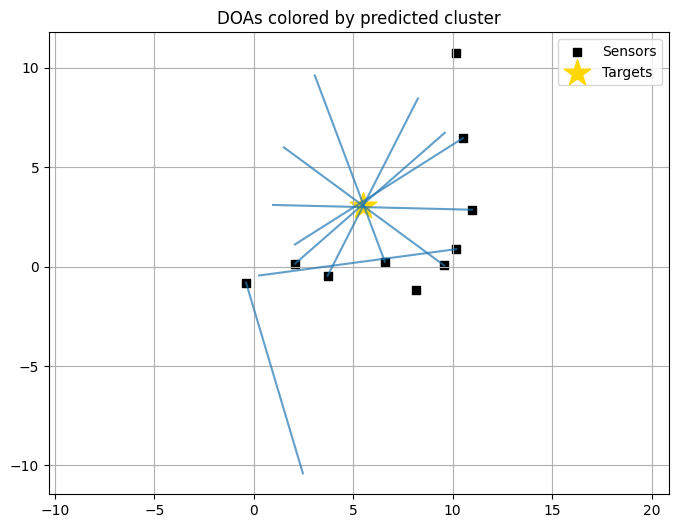

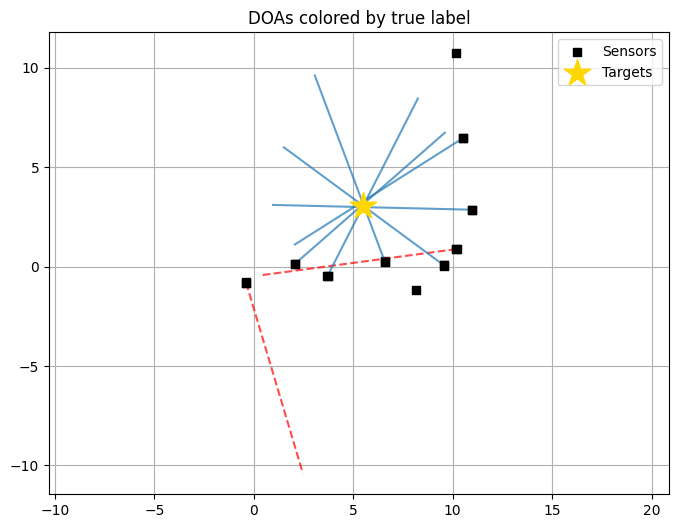

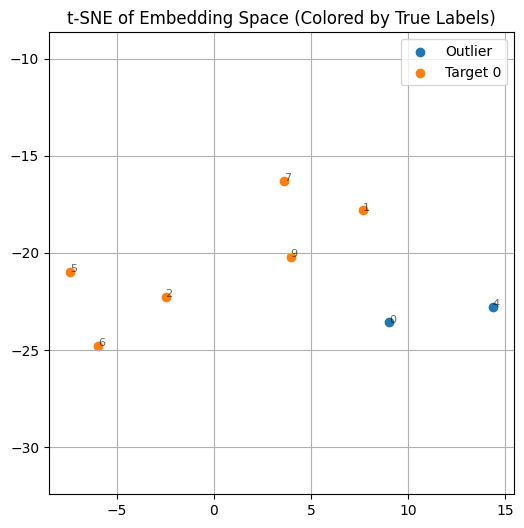

Epoch 11 | loss: 0.2082 (supcon 0.1450, outlier 0.1155, tgt 0.1154, rcos 0.0566, rproto 0.0000) | lr=8.44e-04
Epoch 12 | loss: 0.2329 (supcon 0.1734, outlier 0.1105, tgt 0.1140, rcos 0.0488, rproto 0.0000) | lr=6.92e-04
Epoch 13 | loss: 0.2084 (supcon 0.1485, outlier 0.1075, tgt 0.1257, rcos 0.0440, rproto 0.0000) | lr=5.47e-04
Epoch 14 | loss: 0.2142 (supcon 0.1583, outlier 0.1007, tgt 0.1123, rcos 0.0442, rproto 0.0000) | lr=4.13e-04
Epoch 15 | loss: 0.2183 (supcon 0.1593, outlier 0.1127, tgt 0.1040, rcos 0.0522, rproto 0.0000) | lr=2.94e-04
Epoch 16 | loss: 0.2168 (supcon 0.1522, outlier 0.1109, tgt 0.1302, rcos 0.0546, rproto 0.0000) | lr=1.92e-04
Epoch 17 | loss: 0.1672 (supcon 0.1214, outlier 0.0983, tgt 0.0629, rcos 0.0452, rproto 0.0000) | lr=1.10e-04
Epoch 18 | loss: 0.2288 (supcon 0.1670, outlier 0.1192, tgt 0.1080, rcos 0.0544, rproto 0.0000) | lr=4.99e-05
Epoch 19 | loss: 0.1891 (supcon 0.1460, outlier 0.1010, tgt 0.0387, rcos 0.0506, rproto 0.0000) | lr=1.33e-05
Epoch 20 |

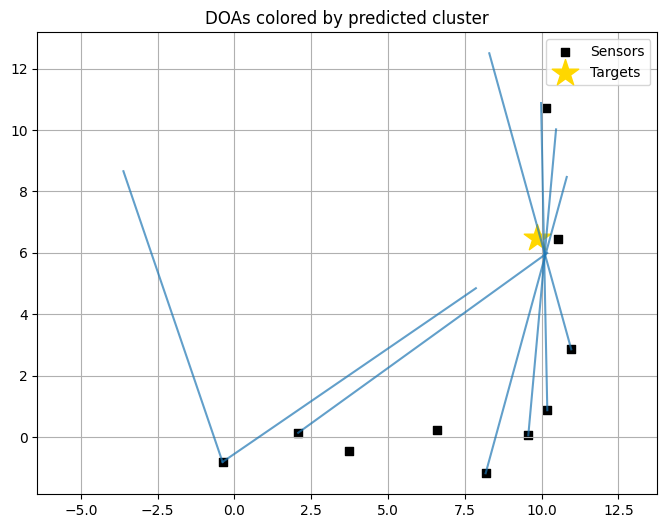

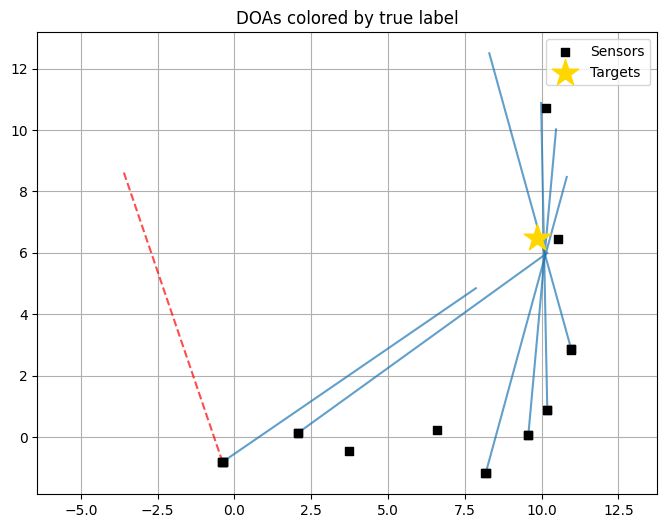

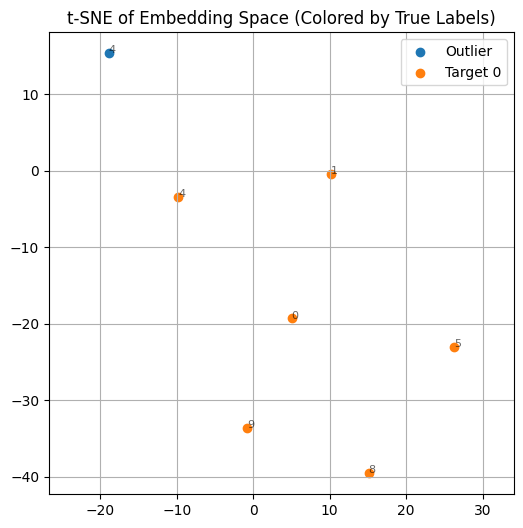

In [15]:
model = EdgeAwareDOAGNN(
    node_dim=4,
    edge_dim=EDGE_FEAT_DIM,   # 13
    hidden=EMBED_DIM,
    num_layers=3,
    emb_dim=16,
    heads=4,
    edge_topk=12,
    dropout=0.1,
    act="gelu",               # <-- try "silu" as well
).to(DEVICE)

train(model)

Predicted number of targets: 1
Outlier scores (sigmoid): [0.00168249 0.01698253 0.00838413 0.04162512 0.10774931 0.00969507
 0.0019671  0.00084714]


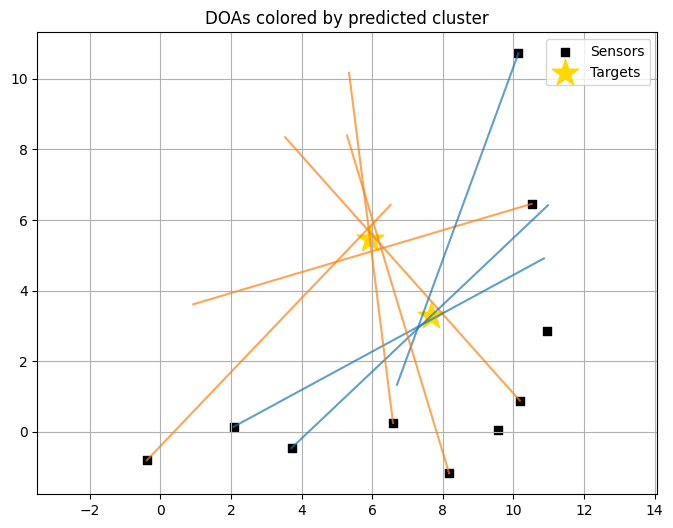

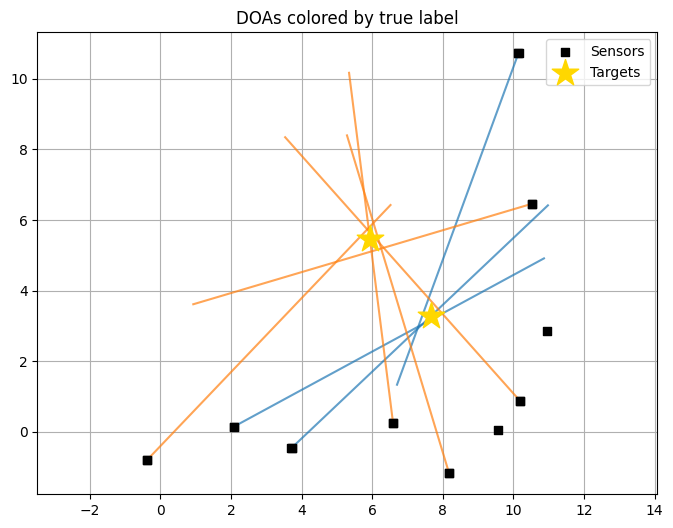

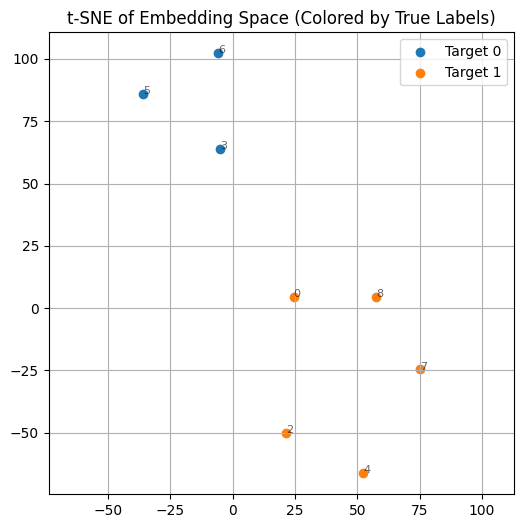

In [70]:
# Final eval on a fresh scene
meas_v, lbls_v, tgt_v, sids_v, n_v, _ = generate_train_scene(epoch=EPOCHS, max_epochs=EPOCHS, p_false=0, num_targets=2, single_per_sensor_ratio=1, p_miss=0.25)
evaluate(model, SENSOR_POSITIONS, sids_v, meas_v, lbls_v, tgt_v, cluster_method="gmm")

In [17]:
def sample_offgrid_targets(num_targets=2,
                           grid_size=GRID_SIZE,
                           min_sep=MIN_TARGET_SEP,
                           avoid_eps=None,
                           max_tries=10000,
                           rng=None):
    """
    Uniformly sample 'num_targets' points in [0, grid_size]^2
    such that:
      - pairwise distance >= min_sep
      - each coordinate is NOT close to a grid lattice value (off-grid)
        i.e., |x - gx| > avoid_eps and |y - gy| > avoid_eps for all grid points gx, gy
    """
    if rng is None:
        rng = np.random.default_rng()
    if avoid_eps is None:
        # ~ quarter of one grid cell if GRID_X/GRID_Y exist; else small absolute epsilon
        if 'GRID_X' in globals() and len(GRID_X) > 1:
            cell = GRID_X[1] - GRID_X[0]
            avoid_eps = 0.25 * float(cell)
        else:
            avoid_eps = max(1e-3, grid_size * 1e-4)

    targets = []
    tries = 0

    # Pre for speed
    grid_x = np.asarray(GRID_X) if 'GRID_X' in globals() else None
    grid_y = np.asarray(GRID_Y) if 'GRID_Y' in globals() else None

    def is_offgrid(x, y):
        if grid_x is None or grid_y is None:
            return True  # if no lattice given, any float is effectively off-grid
        # far from any lattice point (x==gx AND y==gy); enforce margins on both axes
        return (np.abs(grid_x - x).min() > avoid_eps) and (np.abs(grid_y - y).min() > avoid_eps)

    while len(targets) < num_targets and tries < max_tries:
        x = rng.uniform(0.0, grid_size)
        y = rng.uniform(0.0, grid_size)
        tries += 1

        if not is_offgrid(x, y):
            continue
        if targets:
            dists = np.linalg.norm(np.asarray(targets) - np.array([x, y]), axis=1)
            if np.any(dists < min_sep):
                continue
        targets.append([x, y])

    if len(targets) < num_targets:
        raise RuntimeError(f"Could not place {num_targets} off-grid targets with min_sep={min_sep} after {tries} tries.")
    return np.asarray(targets, dtype=np.float32)


Predicted number of targets: 2
Outlier scores (sigmoid): [0.02478306 0.01031816 0.15446003 0.00184257 0.0184023  0.07312566
 0.11749725 0.00889953 0.00730041 0.24028249 0.02412965 0.02615273
 0.01046201 0.009879   0.01926184]


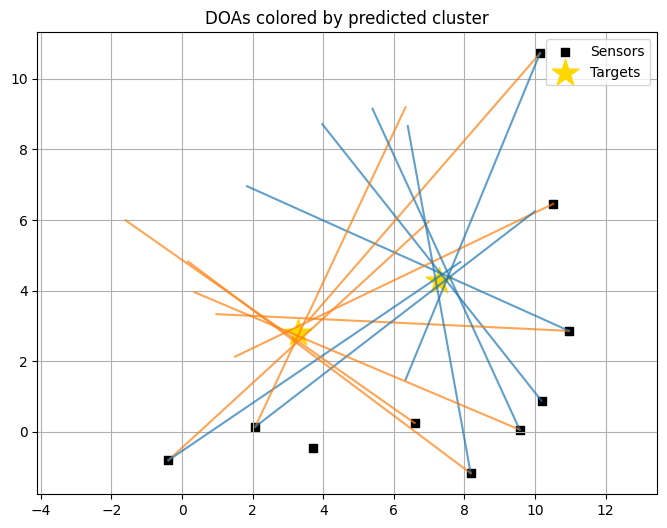

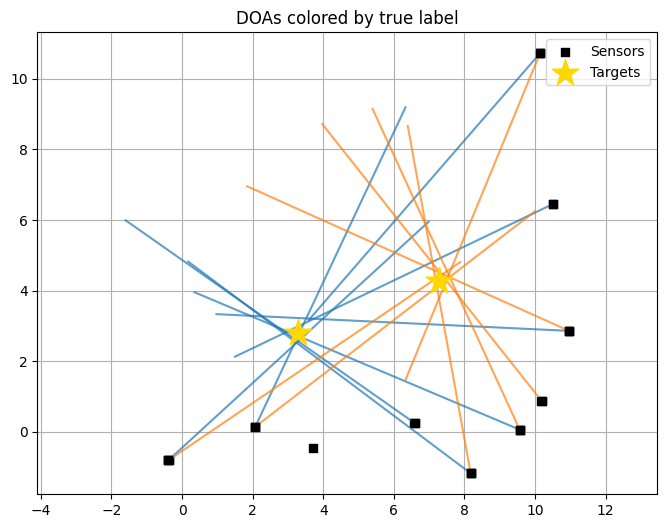

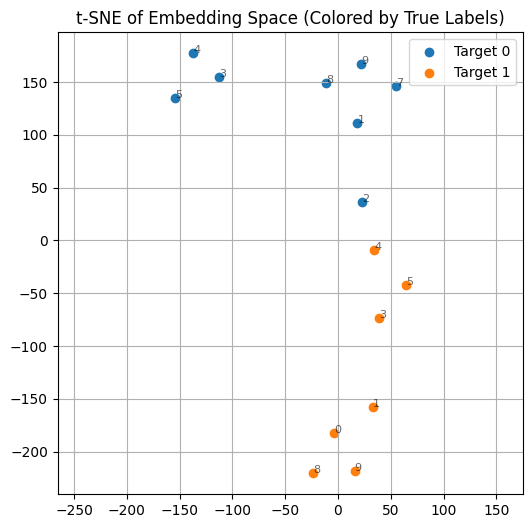

In [189]:
# pick off-grid targets (within bounds, off lattice, well-separated)
tgt_v = sample_offgrid_targets(
    num_targets=2,
    grid_size=GRID_SIZE,
    min_sep=MIN_TARGET_SEP,
    # optional: make “off-grid” margin a bit stricter by bumping avoid_eps
    # avoid_eps=(GRID_X[1]-GRID_X[0]) * 0.3
)

# generate a clean-ish eval scene (no false DOAs; allow some misses)
meas_v, lbls_v, _, sids_v, _ = generate_scene_from_targets(
    SENSOR_POSITIONS,
    tgt_v,
    noise_std=2.0,            # deg stdev noise; tweak as you like
    p_miss=0.25,
    p_false=0.0,
    single_per_sensor_ratio=0.0,
    # if you added min_per_target earlier and want coverage:
    # min_per_target=3,
)

# run your existing visualization/eval
evaluate(model, SENSOR_POSITIONS, sids_v, meas_v, lbls_v, tgt_v, cluster_method="gmm")


In [ ]:
# --- Save final weights (state_dict only) ---
import torch

FINAL_PATH = "/content/final_doagnn_state.pth"
torch.save(model.state_dict(), FINAL_PATH)  # model is your trained EdgeAwareDOAGNN
print("Saved to:", FINAL_PATH)
from google.colab import files
files.download(FINAL_PATH)


Saved to: /content/final_doagnn_state.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Recreate the same architecture
model = EdgeAwareDOAGNN(
    node_dim=4,
    edge_dim=EDGE_FEAT_DIM,  # 13 in our setup
    hidden=EMBED_DIM,
    num_layers=3,
    emb_dim=EMBED_DIM
)

# Load weights (maps GPU tensors to CPU if needed)
state = torch.load("/path/to/final_doagnn_state.pth", map_location="cpu")
model.load_state_dict(state)
model.eval()
